In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Spécifique Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

df = pd.read_csv('../HR_Analytics_Structure_Complet.csv')
print("Données chargées.")

Données chargées.


In [3]:
# 1. Drop corrigé
X_raw = df.drop(['Attrition', 'Attrition_Numeric', 'EmployeeNumber'], axis=1)
y = df['Attrition_Numeric']

# 2. Encodage
X_encoded = pd.get_dummies(X_raw, drop_first=True)

# 3. Scaling (Gardé pour compatibilité)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
X = pd.DataFrame(X_scaled, columns=X_encoded.columns)
features_columns = X_encoded.columns.tolist()

print("--- Préparation terminée ---")
print(f"Nombre de features après encodage : {X.shape[1]}")

--- Préparation terminée ---
Nombre de features après encodage : 45


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Split terminé.")
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Split terminé.
Train shape: (1084, 45)
Test shape: (272, 45)


In [6]:
# 100 arbres par défaut
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Random Forest entraîné.")

Random Forest entraîné.


 BENCHMARK : RANDOM FOREST
Accuracy    : 0.8456
F1-Score    : 0.2500
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       225
           1       0.78      0.15      0.25        47

    accuracy                           0.85       272
   macro avg       0.81      0.57      0.58       272
weighted avg       0.84      0.85      0.80       272



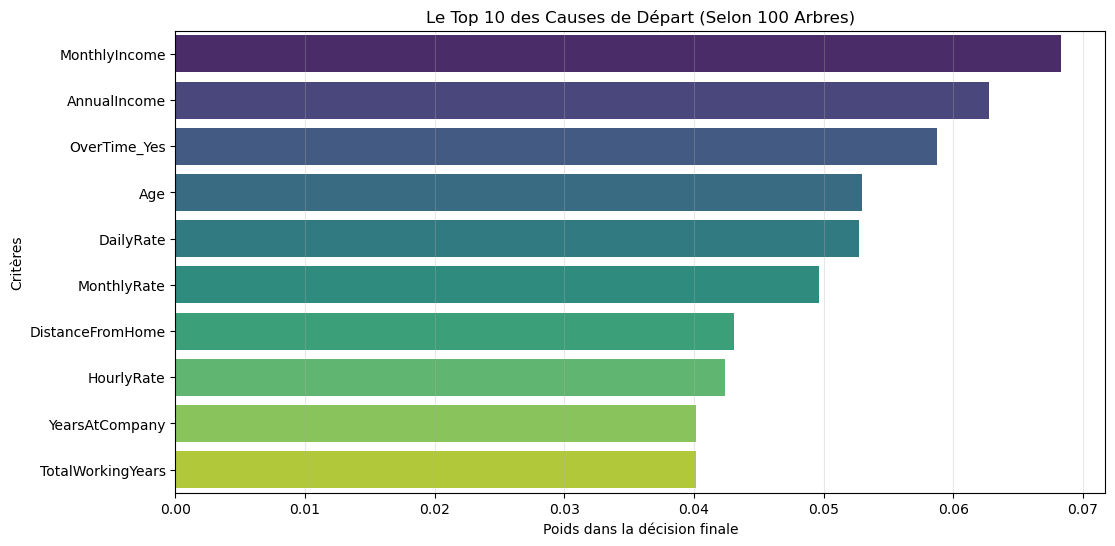

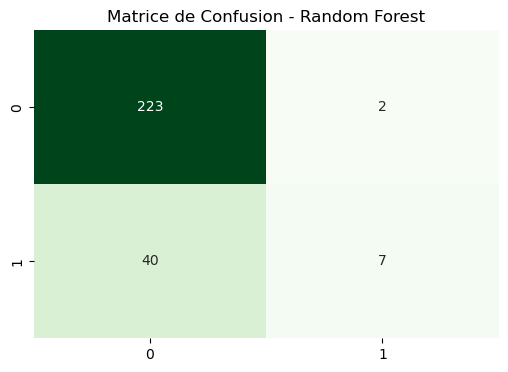

In [11]:
y_pred = model.predict(X_test)

print("="*40)
print(" BENCHMARK : RANDOM FOREST")
print("="*40)
print(f"Accuracy    : {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-Score    : {f1_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

# --- GRAPHIQUE : Top 10 Facteurs ---
importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:10] # On prend les 10 meilleurs

plt.figure(figsize=(12, 6))
plt.title("Le Top 10 des Causes de Départ (Selon 100 Arbres)")
# CORRECTION WARNING (hue et legend)
sns.barplot(x=importances[indices], y=[X.columns[i] for i in indices], hue=[X.columns[i] for i in indices], palette="viridis", legend=False)

plt.xlabel("Poids dans la décision finale")
plt.ylabel("Critères")
plt.grid(axis='x', alpha=0.3)
plt.show()

# Matrice
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title("Matrice de Confusion - Random Forest")
plt.show()

Graphique en Barres : Ce n'est pas positif/négatif comme la Régression Logistique. C'est une mesure d'importance.

-La barre du haut est le "Patron" des critères. Si c'est le Salaire, alors le salaire dicte presque tout. Si c'est OverTime, c'est la surcharge de travail.

-Ce graphique donne la hiérarchie des priorités pour la DRH. Inutile de changer la machine à café (EnvironmentSatisfaction) si le problème n°1 est le salaire.

In [9]:
def predire_demission(input_data, model, scaler, model_columns):
    # 1. DataFrame
    input_df = pd.DataFrame([input_data])
    # 2. Encodage
    input_encoded = pd.get_dummies(input_df)
    # 3. Alignement
    input_encoded = input_encoded.reindex(columns=model_columns, fill_value=0)
    # 4. Scaling
    input_scaled = scaler.transform(input_encoded)
    # 5. DataFrame (Fix Warning)
    input_scaled_df = pd.DataFrame(input_scaled, columns=input_encoded.columns)
    # 6. Prédiction
    proba = model.predict_proba(input_scaled_df)[0][1]
    prediction = "Va Partir (Risque)" if proba > 0.5 else "Va Rester"
    return prediction, proba

# Test
profil_employe = {
    'Age': 29, 'DailyRate': 400, 'DistanceFromHome': 25, 'EnvironmentSatisfaction': 1,
    'JobSatisfaction': 1, 'OverTime': 'Yes', 'Department': 'Sales', 'JobRole': 'Sales Executive'
}
resultat, proba = predire_demission(profil_employe, model, scaler, features_columns)
print(f"Profil Test : {profil_employe}")
print(f"Résultat : {resultat}")
print(f"Probabilité de départ : {proba:.2%}")

Profil Test : {'Age': 29, 'DailyRate': 400, 'DistanceFromHome': 25, 'EnvironmentSatisfaction': 1, 'JobSatisfaction': 1, 'OverTime': 'Yes', 'Department': 'Sales', 'JobRole': 'Sales Executive'}
Résultat : Va Partir (Risque)
Probabilité de départ : 67.00%


In [10]:
artefacts = {
    'model': model,
    'scaler': scaler,
    'features': features_columns
}
joblib.dump(artefacts, '../Models/modele_classif_random_forest.pkl')
print("Sauvegardé : '../Models/modele_classif_random_forest.pkl'")

Sauvegardé : '../Models/modele_classif_random_forest.pkl'


Conclusion :

 Le Random Forest est généralement le modèle le plus performant et le plus stable. Le graphique "Feature Importance" est un outil décisionnel puissant pour les RH : il montre immédiatement sur quels leviers agir (ex: Salaire, Distance, Heures Supp) pour retenir les talents.